In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [70]:
class TimeSeriesPred:
    def __init__(self,dataframe,seq_len=10,output_file='predictions.csv'):
        self.df = dataframe
        self.a = dataframe
        self.seq_len = seq_len
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.Model = None
        self.X_train,y_train,X_test,y_test = None,None,None,None
        self.prediction,self.actual = None,None
        self.k = None
        self.output_file = output_file
    
    def preprocess_data(self):   
        self.a =  self.df[[	"Temperature1","Temperature2","Pressure1","Pressure2"]].copy()
        random.seed(42)
        l = [random.randint(0,1) for _ in range(self.a.shape[0])]
        
        self.a["Status"] = l    

        self.data_scaled = self.scaler.fit_transform(self.a)
        X,y = self.create_seq(self.data_scaled)   

        train_size = int(0.8*len(X))
        self.X_train,self.X_test = X[:train_size],X[train_size:]
        self.y_train,self.y_test = y[:train_size],y[train_size:]

    def create_seq(self,data):
        X,y = [],[]
        for i in range(len(data) - self.seq_len):
            X.append(data[i:i+self.seq_len,:])
            y.append(data[i+self.seq_len,:])

        return np.array(X),np.array(y)  
    
    def create_model(self):
        self.model = Sequential()
        self.model.add(LSTM(64,return_sequences = True,activation = 'tanh',input_shape = (self.X_train.shape[1],self.X_train.shape[2])))
        self.model.add(LSTM(64,activation = 'tanh'))
        self.model.add(Dense(self.a.shape[1]))
        self.model.compile(loss = 'mean_squared_error',optimizer = 'adam',metrics = ['accuracy'])


    def train_model(self,epochs = 50,batch_size = 64):
        self.model.fit(self.X_train,self.y_train,epochs = epochs,batch_size = batch_size,validation_data = (self.X_test,self.y_test))
                                                                                         
    def predict(self):
        self.prediction = self.model.predict(self.X_test)
        self.prediction = self.scaler.inverse_transform(self.prediction)
        self.actual = self.scaler.inverse_transform(self.y_test)

        columns = [	"Temperature1","Temperature2","Pressure1","Pressure2","Status"]
        self.pred_df = pd.DataFrame(self.prediction, columns=columns)
        self.pred_df['Status'] = (self.pred_df['Status'] >= 0.5).astype(int)

        self.pred_df.to_csv(self.output_file,index = False)
        print(f"predictions saved to {self.output_file}")

    def plot_pred(self):
        columns = ["Temperature1", "Temperature2", "Pressure1", "Pressure2", "Status"]
        actual_df = pd.DataFrame(self.actual, columns=columns)

        plt.figure(figsize=(16, 16))

        for i, column in enumerate(columns):
            plt.subplot(len(columns), 1, i+1)
            plt.plot(actual_df[column], label='Actual ' + column, color='blue')
            plt.plot(self.pred_df[column], label='Predicted ' + column, color='orange')
            plt.title(column + ' (Actual vs Predicted)')
            plt.xlabel('Time Steps')
            plt.ylabel(column)
            plt.legend()
        plt.tight_layout()
        plt.show()

In [71]:
def main_one(input_csv_path,output_csv_path):    
   
    df = pd.read_csv(input_csv_path)    
    Pred = TimeSeriesPred(df, seq_len=10, output_file=output_csv_path)   
    Pred.preprocess_data()    
    Pred.create_model()    
    Pred.train_model(epochs=50, batch_size=64)      
    Pred.predict()    
    Pred.plot_pred()    


In [72]:
class Regression:
    def __init__(self, input_csv):
        self.df = pd.read_csv(input_csv)        
        #self.X_train, self.y_train, self,X_test, self.y_test = None, None, None, None
        self.X_train, self.y_train, self.X_test, self.y_test = None, None, None, None
        self.model = None
        self.scalar = StandardScaler()


    def preprocess_data(self):
        self.X = self.df.iloc[:,:-1].values
        self.y = self.df.iloc[:,-1].values
        self.X = self.scalar.fit_transform(self.X)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.05, random_state=0)
        #self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.05, random_state=0)



    def create_model(self):
        self.model = Sequential()
        self.model.add(Dense(5,activation = 'relu',input_shape = (self.X_train.shape[1],)))
        self.model.add(Dense(32,activation = 'relu'))
        self.model.add(Dense(64,activation = 'relu'))
        self.model.add(Dense(1))
        self.model.compile(loss = 'mean_squared_error',optimizer = 'adam',metrics = ['accuracy'])

    def train_model(self, epochs = 50,batch_size = 64):
        self.model.fit(self.X_train,self.y_train,epochs = epochs,batch_size = batch_size,validation_data=(self.X_test, self.y_test))

    def predict(self):
        y_pred = self.model.predict(self.X_test)
        y_pred = (y_pred >= 0.5).astype(int)
        return y_pred.flatten()
 
    def plot_predictions(self, y_pred):
        plt.figure(figsize=(10, 6))
        plt.plot(self.y_test, label='Actual Values', color='blue')
        plt.plot(y_pred, label='Predicted Values', color='orange')
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Samples')
        plt.ylabel('Values')
        plt.legend()
        plt.show() 
       


In [73]:
def main_two(input_csv_path):
    model = Regression(input_csv_path)
    model.preprocess_data()
    model.create_model()
    model.train_model(epochs=50, batch_size=64)         
    
    y_pred = model.predict()
    model.plot_predictions(y_pred) 
    
     


Epoch 1/50


c:\Users\91995\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3660 - loss: 0.1704 - val_accuracy: 0.4683 - val_loss: 0.0763
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3465 - loss: 0.1032 - val_accuracy: 0.4683 - val_loss: 0.0722
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3419 - loss: 0.1007 - val_accuracy: 0.4802 - val_loss: 0.0718
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3332 - loss: 0.0997 - val_accuracy: 0.4697 - val_loss: 0.0709
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3009 - loss: 0.0992 - val_accuracy: 0.4894 - val_loss: 0.0701
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3310 - loss: 0.0990 - val_accuracy: 0.4894 - val_loss: 0.0685
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3044 - loss: 0.0972 - val_accuracy: 0.4894 - val_loss: 0.0683
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3233 - loss: 0.0980 - val_accuracy: 0.5185 - val_loss: 0.0682
Ep

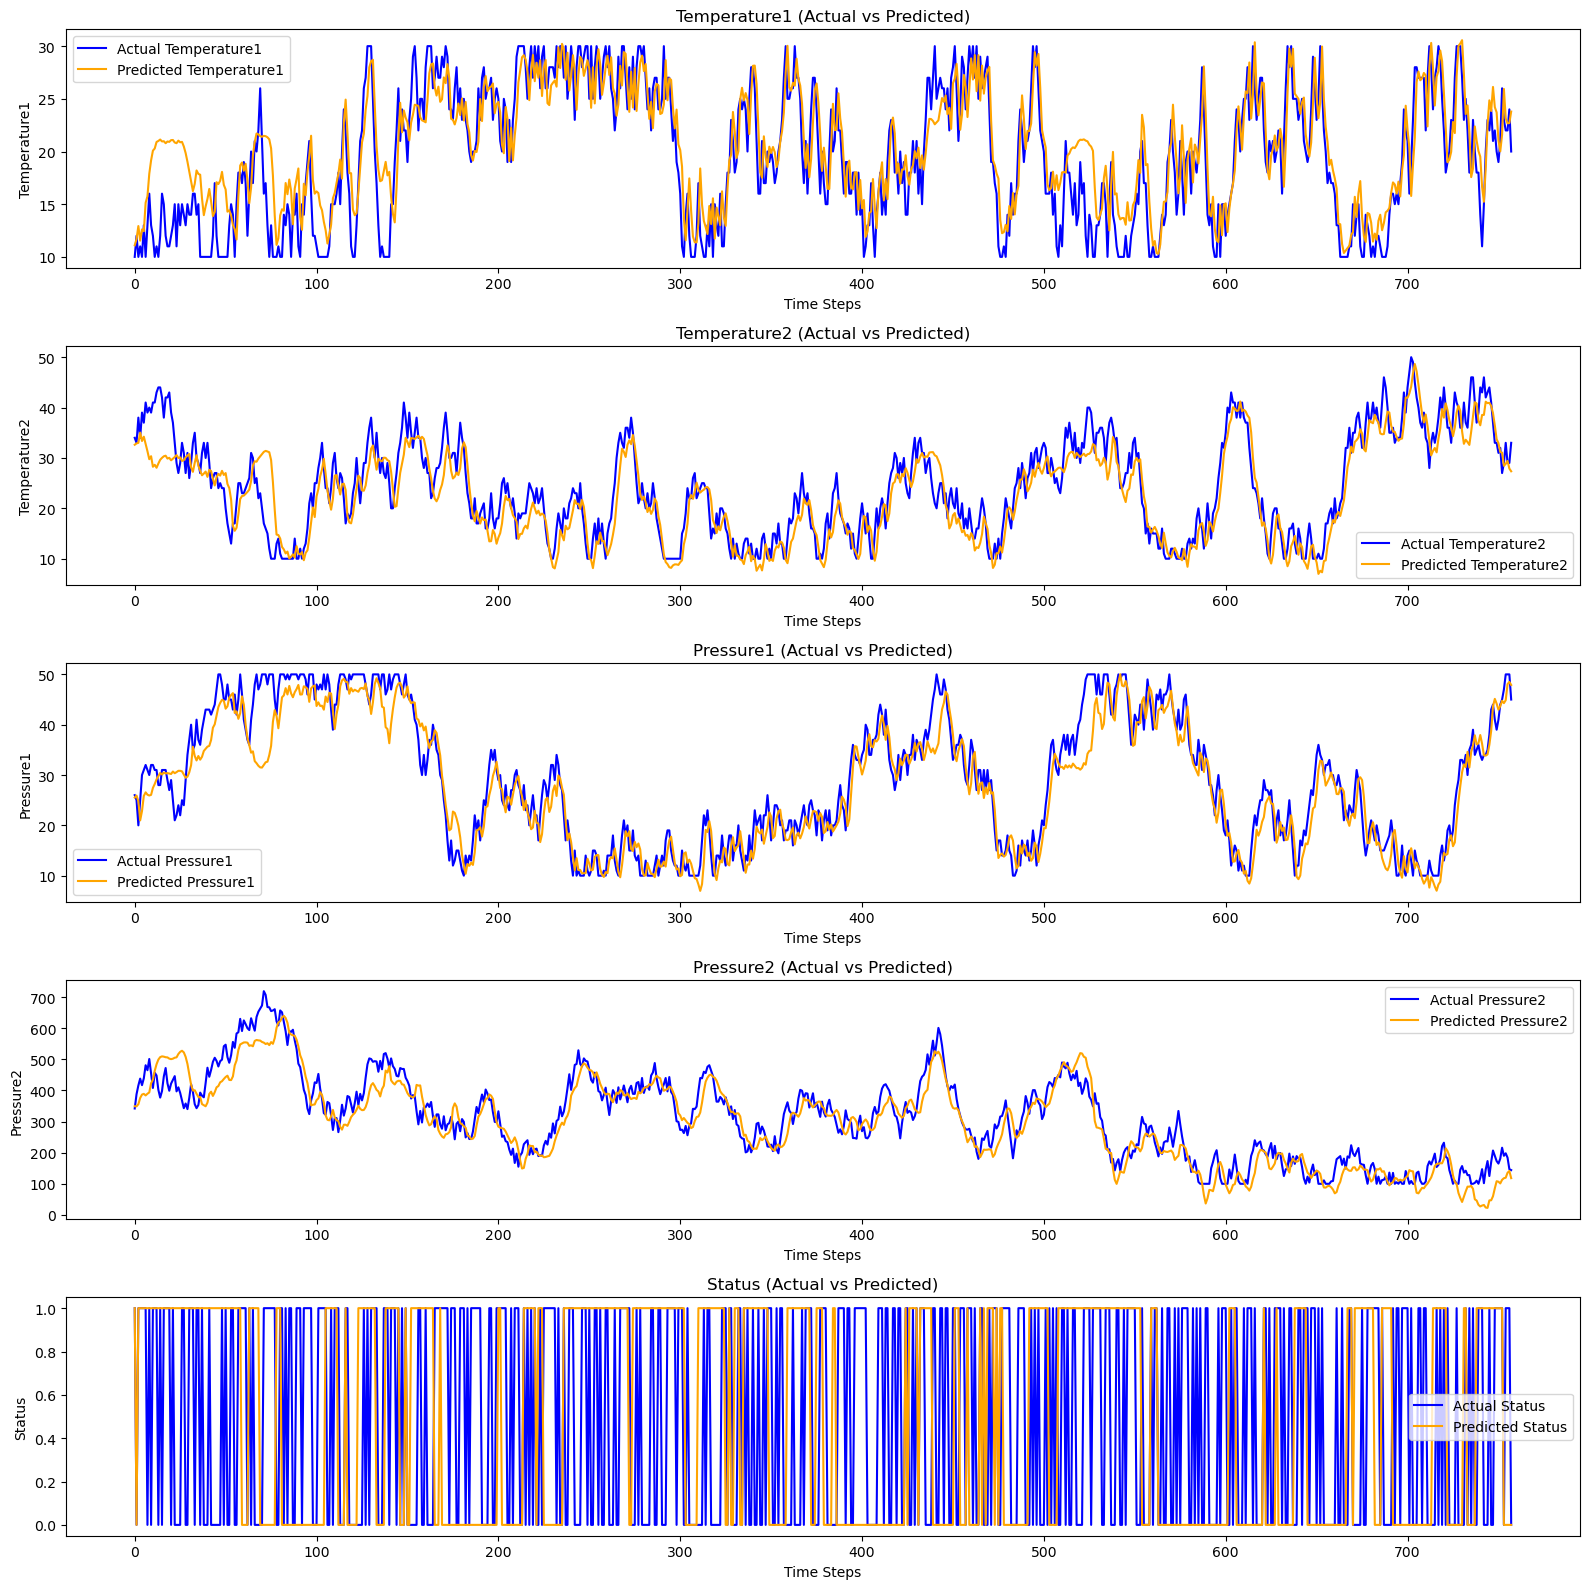

Epoch 1/50


c:\Users\91995\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4870 - loss: 0.5376 - val_accuracy: 0.4474 - val_loss: 0.2920
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5205 - loss: 0.2579 - val_accuracy: 0.6053 - val_loss: 0.2152
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5758 - loss: 0.2606 - val_accuracy: 0.6842 - val_loss: 0.2059
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6035 - loss: 0.2352 - val_accuracy: 0.7368 - val_loss: 0.2029
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6414 - loss: 0.2208 - val_accuracy: 0.6842 - val_loss: 0.1934
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6738 - loss: 0.2078 - val_accuracy: 0.7105 - val_loss: 0.1882
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6983 - loss: 0.2031 - val_accuracy: 0.7368 - val_loss: 0.1822
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7098 - loss: 0.1992 - val_accuracy: 0.7632 - val_loss: 0.1741
Ep

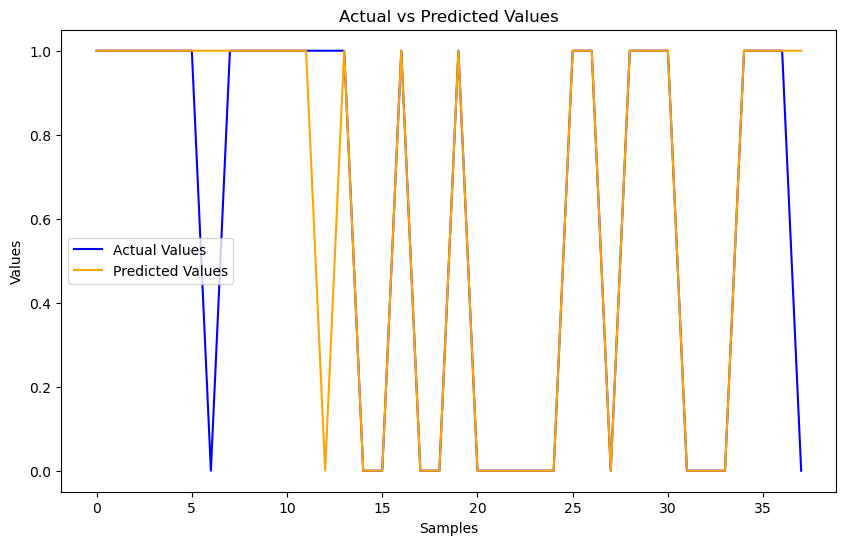

In [74]:
if __name__ == "__main__":
    main_one('machine_data.csv','predictions.csv')
    main_two('predictions.csv' )